In [110]:
import copy
import dicom2nifti
import dicom2nifti.compressed_dicom as compressed_dicom
import importlib
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as regs
import niftiutils.visualization as vis
import keras
import keras.layers as layers
import numpy as np
import os
from os.path import *
import glob
import pandas as pd
import pylab
import shutil
import config
import cnn_builder as cbuild
from keras.models import Model
import dcgan as dcg
from keras.callbacks import EarlyStopping
%matplotlib inline

In [108]:
importlib.reload(config)
importlib.reload(cbuild)
C = config.Config()

model = cbuild.build_cnn(lr=.002)
model.summary()

#early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=3)

In [ ]:
hist = model.fit_generator(cbuild.train_generator(), steps_per_epoch=15, epochs=100)#, callbacks=[early_stopping])

In [140]:
X,Y=next(cbuild.train_generator())

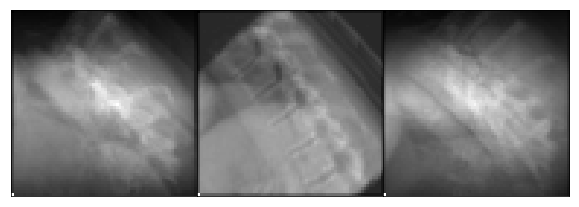

In [141]:
vis.draw_slices(X[0], normalize=[0,1])

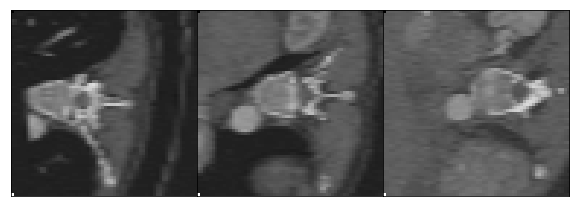

In [142]:
vis.draw_slices(tr.rescale_img(Y[0], [1]*3, [2,1,1]), normalize=[0,1])

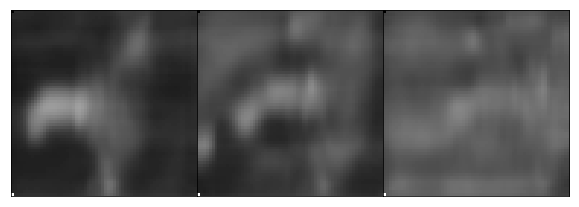

In [143]:
#y_pred = model.predict(X[:1])[0]
y_pred = dcgan.generator.predict(X[:1])[0]
vis.draw_slices(tr.rescale_img(y_pred, [1]*3, [2,1,1]), normalize=[0,1])

In [111]:
model_ix = 0
dcgan.generator.save(join(C.model_dir, "dcgan_G_%d.hdf5" % model_ix))
dcgan.discriminator.save(join(C.model_dir, "dcgan_D_%d.hdf5" % model_ix))
dcgan.combined.save(join(C.model_dir, "dcgan_C_%d.hdf5" % model_ix))

In [ ]:
layers.BatchNormalization()

In [ ]:
importlib.reload(dcg)
dcgan = dcg.DCGAN()
dcgan.train(epochs=10000, batch_size=8, save_interval=100)

In [92]:
img_dir = r"D:\CBCT\Test\AARON"
dcm_path = img_dir+"\\15814.dcm"

In [96]:
dicom_input = hf.load_dcm_header(dcm_path)[0]

In [105]:
cine_rate = float(dicom_input[('0018', '0040')].value)
kvp = float(dicom_input[('0018', '0060')].value)
d_detector = int(dicom_input[('0018', '1110')].value)
d_patient = int(dicom_input[('0018', '1111')].value)
t_exposure = int(dicom_input[('0018', '1150')].value)
current = int(dicom_input[('0018', '1151')].value)
exposure = int(dicom_input[('0018', '1152')].value)
pixel_spacing = dicom_input[('0018', '1164')].value
angle1 = float(dicom_input[('0018', '1510')].value)
angle2 = float(dicom_input[('0018', '1511')].value)
angle1_increment = dicom_input[('0018', '1520')].value
angle2_increment = dicom_input[('0018', '1521')].value
shutter_edges = [int(dicom_input[('0018', str(x))].value) for x in [1602, 1604, 1606, 1608]]

In [98]:
proj_imgs, _ = hf.dcm_load(dcm_path)
proj_imgs = np.transpose(proj_imgs, (1,2,0))
proj_imgs_unscaled = copy.deepcopy(proj_imgs)
proj_imgs = (proj_imgs - np.amin(proj_imgs)) / (np.amax(proj_imgs) - np.amin(proj_imgs))

In [82]:
proj_imgs = proj_imgs[:, :, 50:-50]
rows, frames, cols = proj_imgs.shape

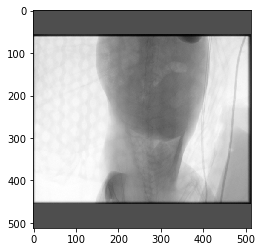

In [102]:
proj_imgs = np.transpose(proj_imgs, (2,0,1))
pylab.imshow(proj_imgs[:,:,100], cmap='gray')

In [104]:
proj_imgs.shape[-1]

308

In [103]:
len(angle1_increment)

311

In [84]:
proj_imgs.shape

(512, 308, 512)

In [ ]:
import astra

In [394]:
rec_cropped = rec[:,10:120,20:170]
rec_cropped[rec_cropped < 0] = 0
rec_cropped = np.transpose(rec_cropped, (2,1,0))

In [395]:
rec_cropped = rec_cropped * -1

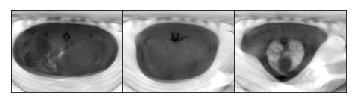

In [366]:
hf.draw_slices(rec_cropped)

In [306]:
print(np.amin(rec[80,10:120,20:170]), np.amax(rec[80,10:120,20:170]))

-59.913471

pylab.imshow(np.transpose(rec[:,:,::-1][50,20:170,10:120], (1,0)), vmin=0.0005)

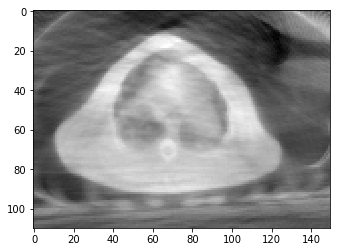

In [23]:
pylab.imshow(rec[100,10:120,20:170])#, vmin=-50, vmax=150) #vmin=.0010, vmax=0.0035)

In [27]:
recon_img = hf.dcm_load(img_dir+"\\15810.dcm")
recon_img = np.transpose(recon_img, (1,2,0))[::-1,:,:]